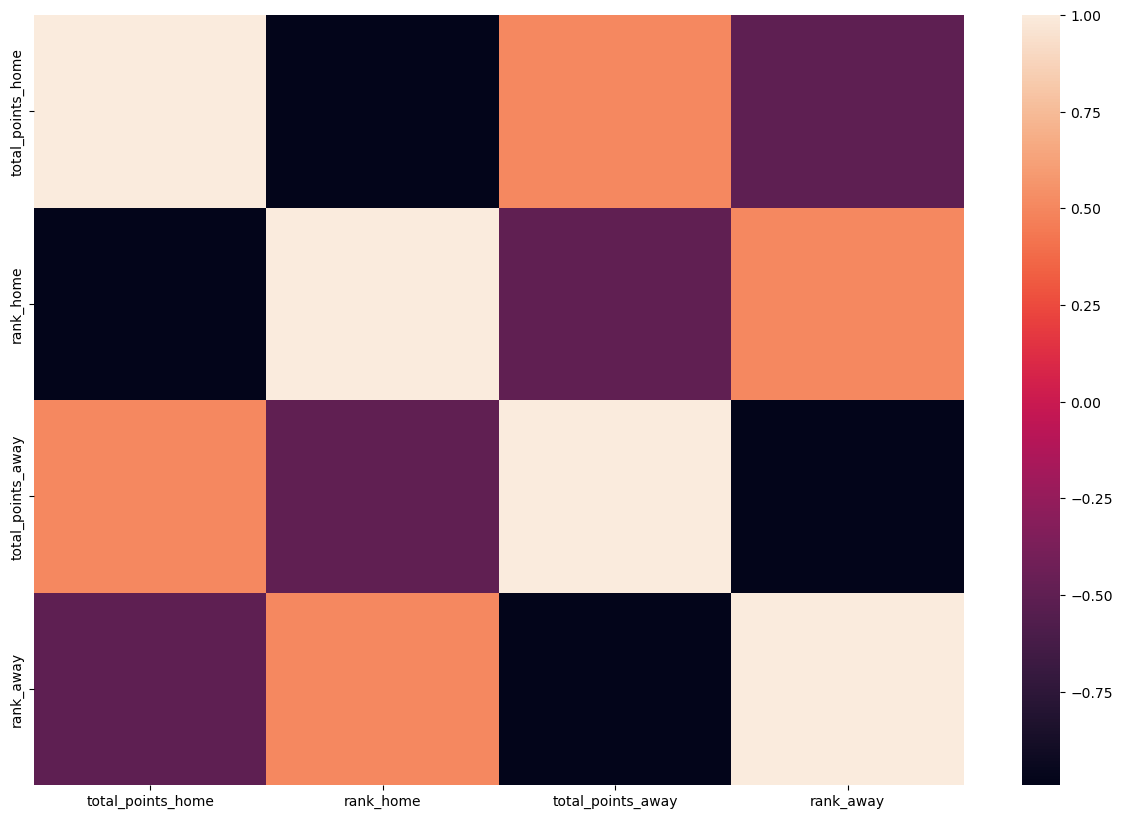

/var/folders/bz/gcsrd6rx409fywqs281zm_ww0000gn/T/ipykernel_28256/1360913857.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  team_stats = home_team.append(away_team).sort_values("date")


In [126]:
import os
for dirname, _, filenames in os.walk('/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import numpy as np # linear algebra        
import pandas as pd
import re

df =  pd.read_csv("input/results.csv")
df["date"] = pd.to_datetime(df["date"])
df.isna().sum()
df.dropna(inplace=True)
df.sort_values("date").tail()
df = df[(df["date"] >= "2018-8-1")].reset_index(drop=True)
df.sort_values("date").tail()
df.home_team.value_counts()


rank = pd.read_csv("input/fifa_ranking-2022-10-06.csv")
rank["rank_date"] = pd.to_datetime(rank["rank_date"])
rank = rank[(rank["rank_date"] >= "2018-8-1")].reset_index(drop=True)
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

df_wc_ranked = df.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)

df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

df_wc_ranked[(df_wc_ranked.home_team == "Brazil") | (df_wc_ranked.away_team == "Brazil")].tail(10)

df = df_wc_ranked

def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)

df[["result", "home_team_points", "away_team_points"]] = results


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.heatmap(df[["total_points_home", "rank_home", "total_points_away", "rank_away"]].corr())
plt.show()

df["rank_dif"] = df["rank_home"] - df["rank_away"]
df["sg"] = df["home_score"] - df["away_score"]
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]

home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]

home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]


team_stats = home_team.append(away_team).sort_values("date")

team_stats_raw = team_stats.copy()

stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)
    
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]#qtd de pontos ganhos
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
    else:
        points = 0
        points_l5 = 0
        
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])
    
    
stats_cols = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]


home_team_stats.columns[-12:]

home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

full_df.columns

def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

full_df = pd.get_dummies(full_df, columns=["is_friendly"])

full_df.columns


base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5',
       'is_friendly_0', 'is_friendly_1']]

base_df.tail()

base_df.isna().sum()

base_df_no_fg = base_df.dropna()


# Data Analysis


/var/folders/bz/gcsrd6rx409fywqs281zm_ww0000gn/T/ipykernel_28256/754464180.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"] = df["result"].apply(lambda x: no_draw(x))


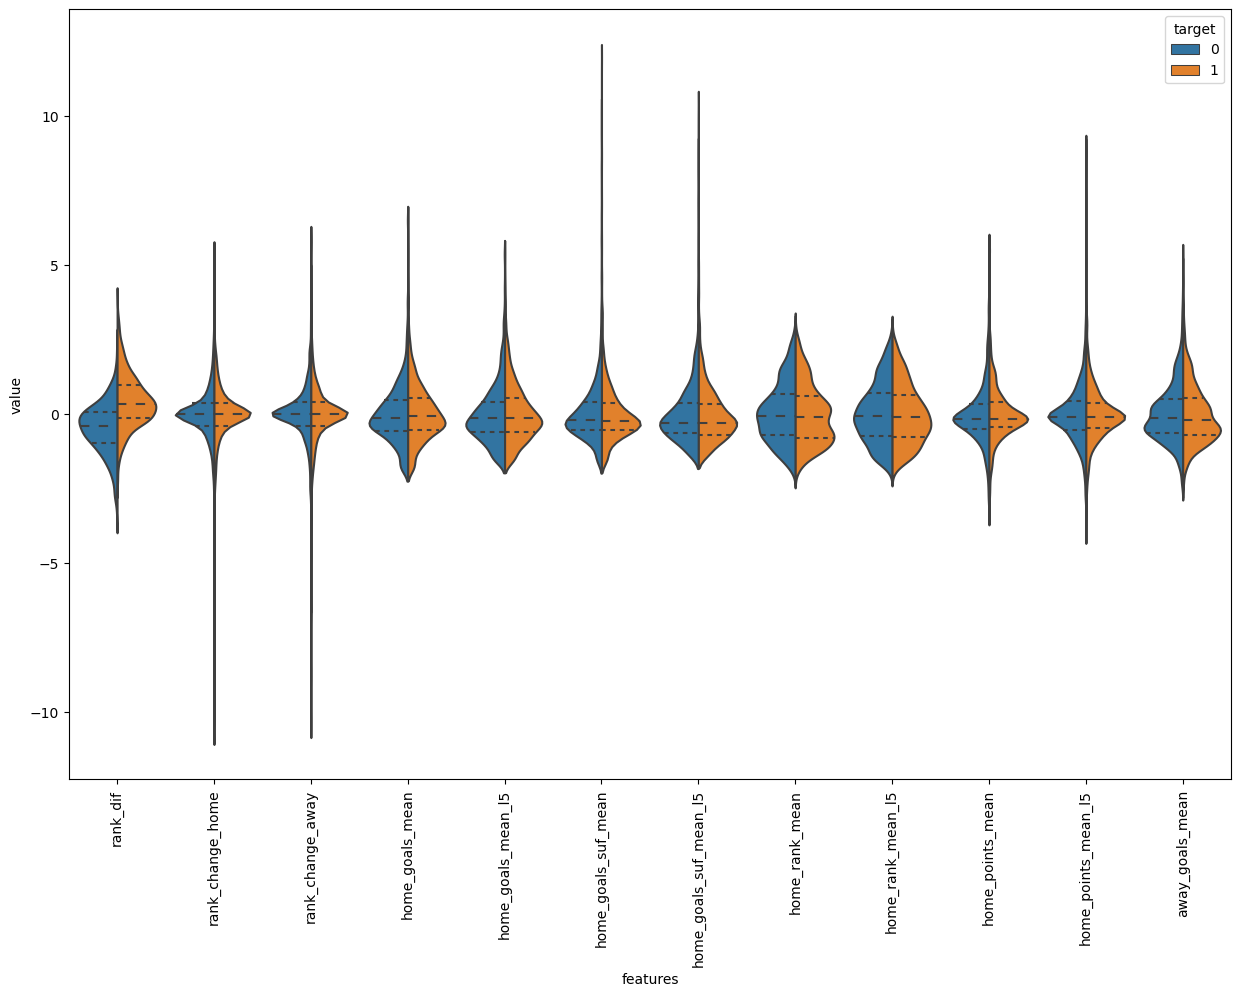

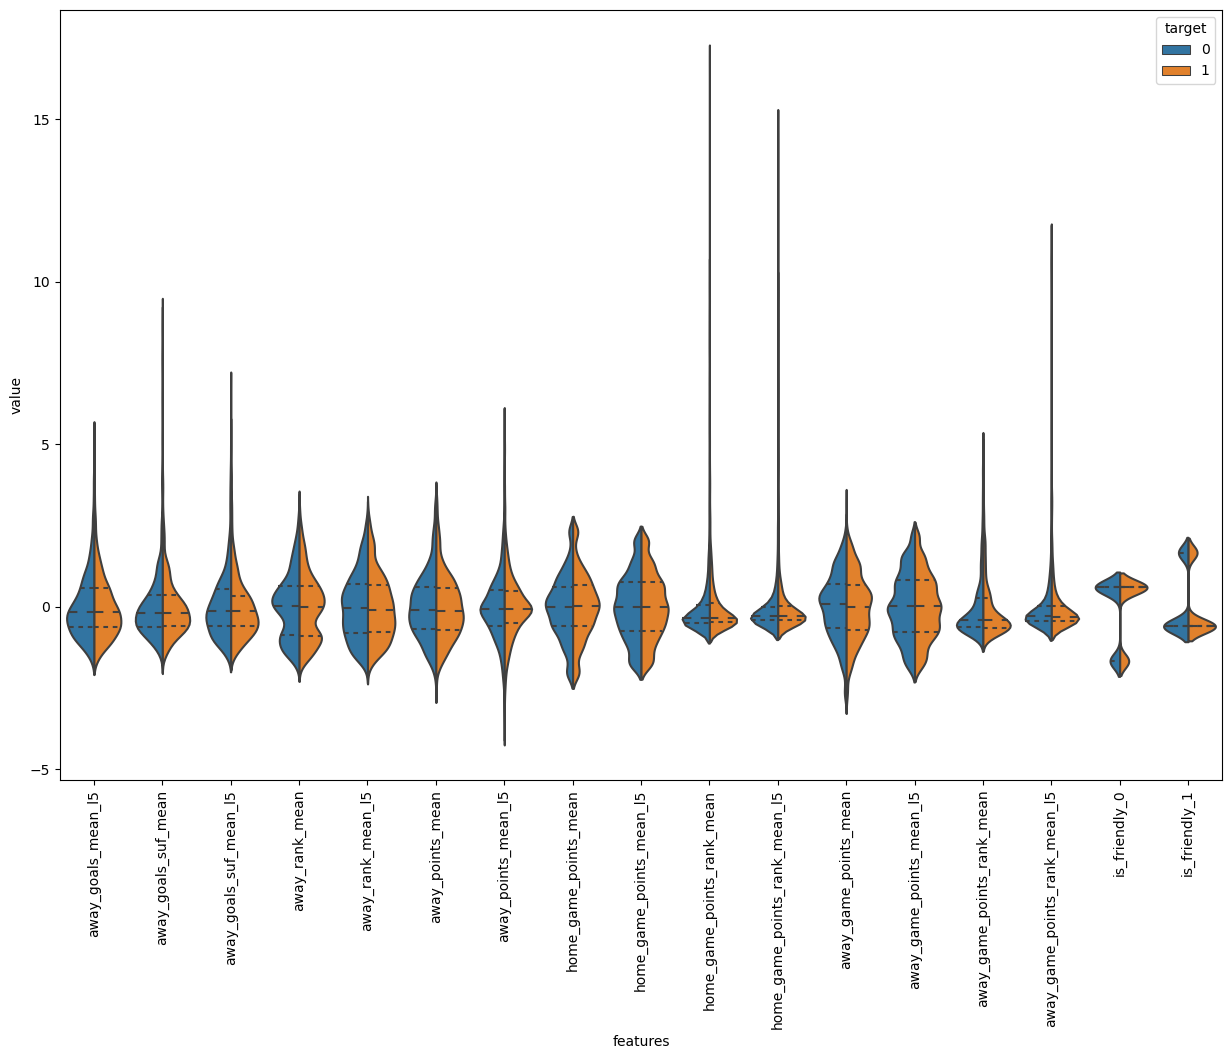

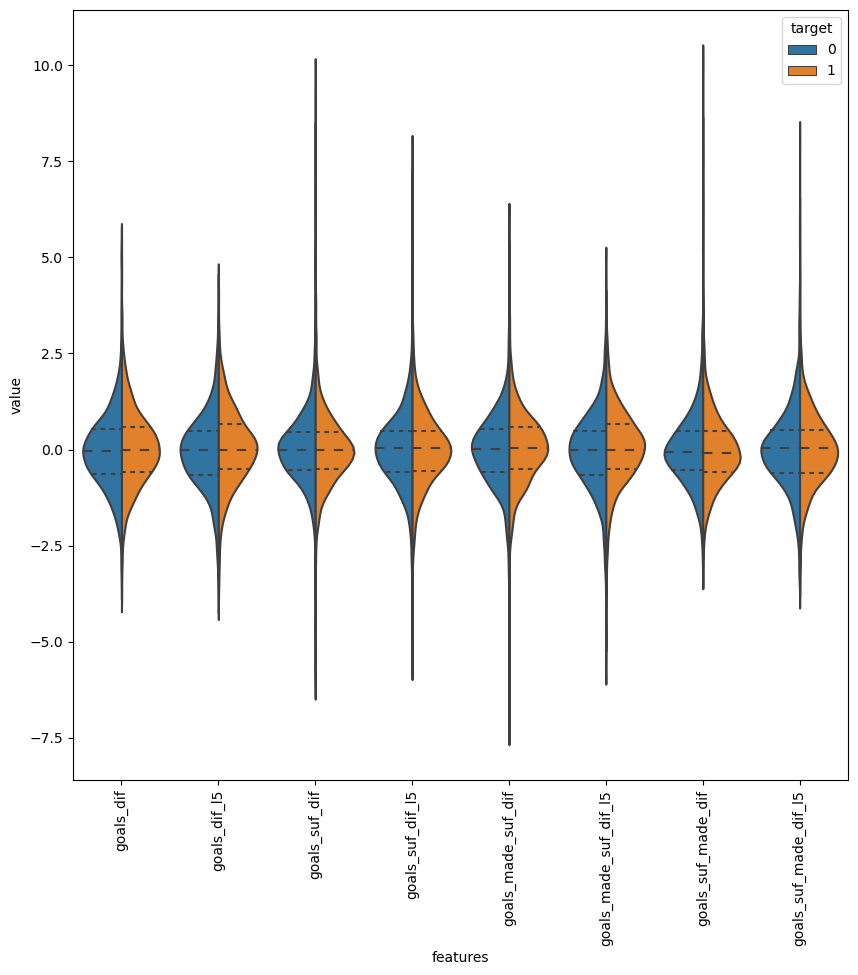

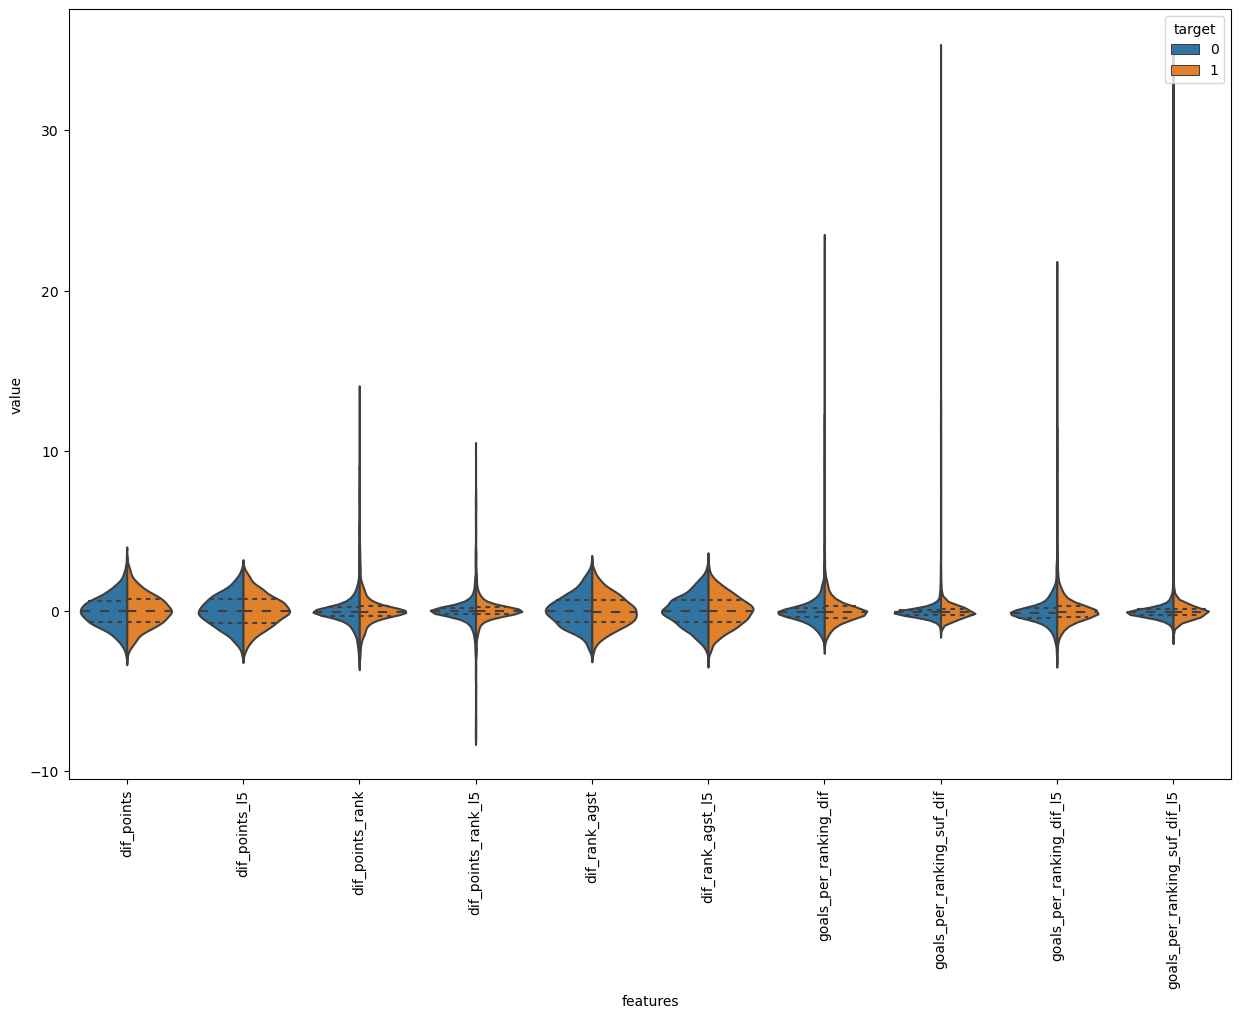

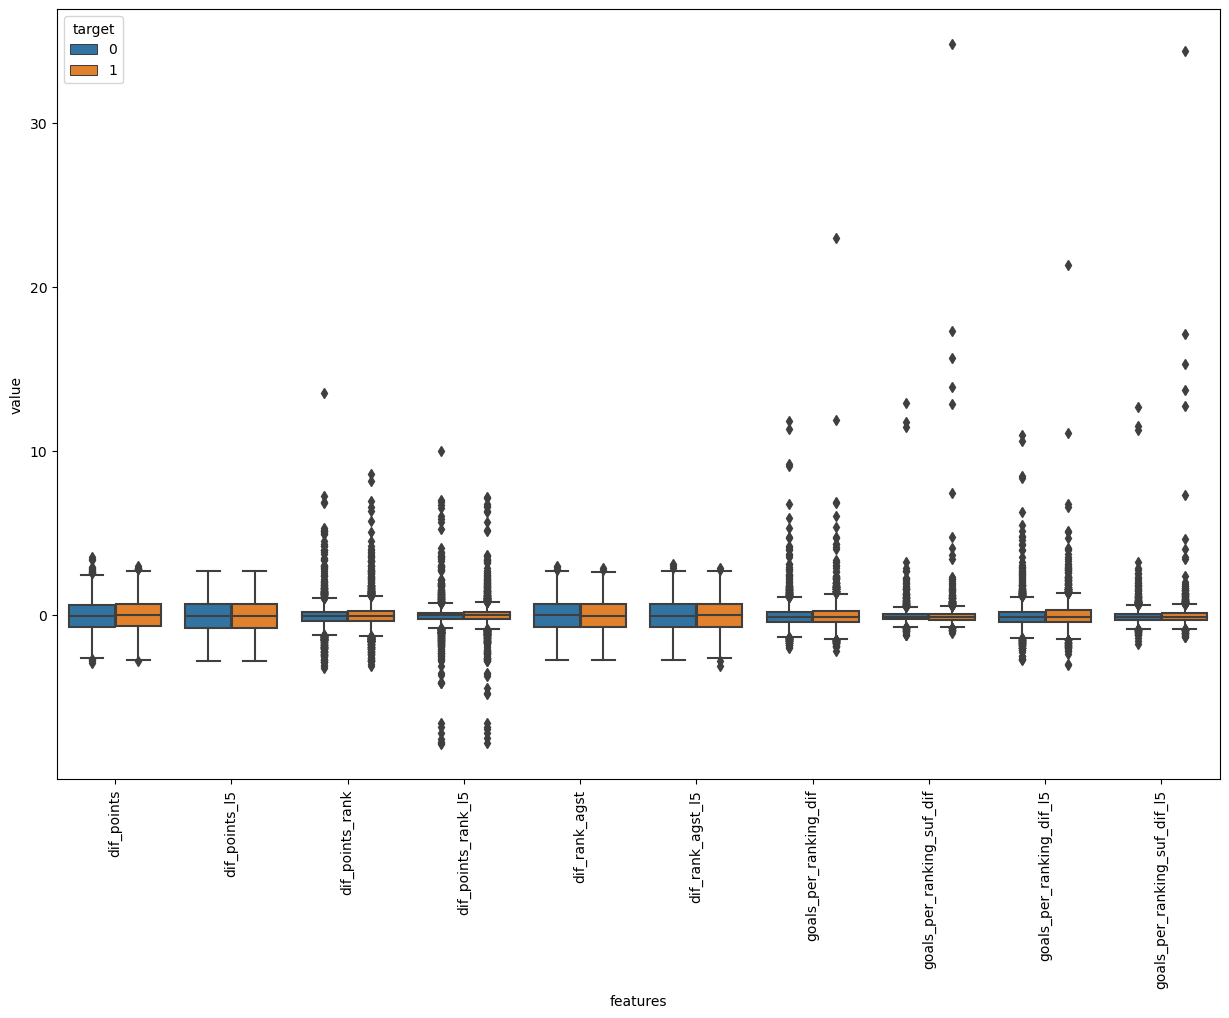

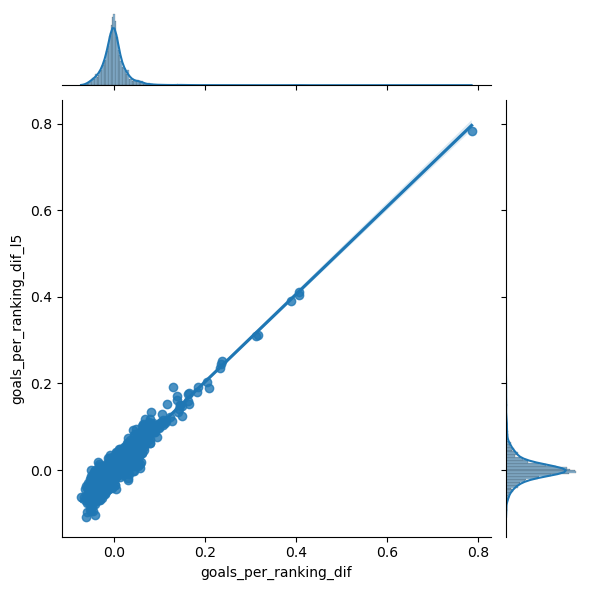

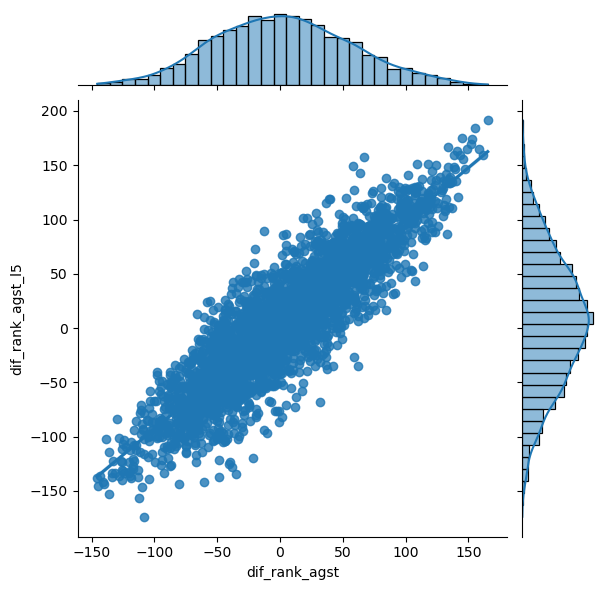

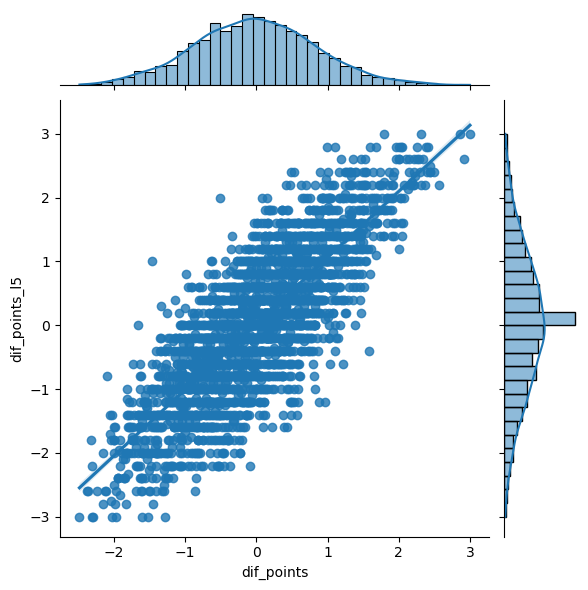

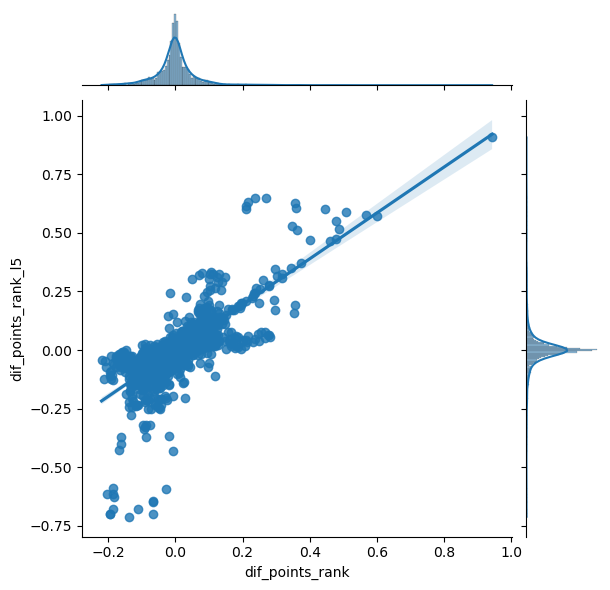

,home_team,away_team,target,rank_dif,goals_dif,goals_dif_l5,goals_suf_dif,goals_suf_dif_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,dif_points_rank,dif_points_rank_l5,is_friendly_0,is_friendly_1
7,Macau,Solomon Islands,1,42.0,4.222222,4.6,-0.666667,-0.4,0.023567,42.444444,49.2,0.014003,0.013910,0,1
8,Ethiopia,Burundi,1,3.0,1.000000,1.4,0.208333,0.2,0.023614,-20.500000,-30.4,0.010315,0.010417,0,1
9,Mongolia,Macau,0,1.0,-1.391304,-1.4,0.173913,0.8,-0.015976,58.913043,30.8,-0.019160,-0.019187,1,0
11,Nepal,Pakistan,1,-40.0,-1.076923,-1.4,-0.500000,-0.5,-0.008378,24.461538,41.8,-0.004618,-0.004854,1,0
13,Fiji,Solomon Islands,1,22.0,-1.250000,-1.6,0.333333,0.4,-0.049931,79.000000,82.3,-0.129638,-0.192116,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3331,Norway,Serbia,1,11.0,-0.907292,0.0,-0.023958,0.4,-0.022721,47.846875,42.8,-0.031560,-0.024106,1,0
3332,Sweden,Slovenia,1,-45.0,-0.129199,-0.6,-1.356589,-0.2,-0.003367,25.953488,-24.6,0.003728,0.001278,1,0
3333,Kosovo,Cyprus,0,-2.0,0.065891,0.0,-0.684109,-0.2,-0.004438,58.581395,48.8,-0.003332,-0.016551,1,0
3334,Greece,Northern Ireland,0,-9.0,-0.746667,-0.6,-0.302222,-0.6,-0.000491,-65.806667,-62.2,0.005266,0.006542,1,0


In [127]:
df = base_df_no_fg

def no_draw(x):
    if x == 2:
        return 1
    else:
        return x
    
df["target"] = df["result"].apply(lambda x: no_draw(x))

data1 = df[list(df.columns[8:20].values) + ["target"]]
data2 = df[df.columns[20:]]

scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
scaled["target"] = data1["target"]
violin1 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

scaled = (data2[:-1] - data2[:-1].mean()) / data2[:-1].std()
scaled["target"] = data2["target"]
violin2 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin1,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin2,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

dif = df.copy()
dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_mean_l5"]

data_difs = dif.iloc[:, -8:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()


dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]
dif.loc[:, "dif_points_l5"] = dif["home_game_points_mean_l5"] - dif["away_game_points_mean_l5"]
dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]
dif.loc[:, "dif_points_rank_l5"] = dif["home_game_points_rank_mean_l5"] - dif["away_game_points_rank_mean_l5"]

dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]
dif.loc[:, "dif_rank_agst_l5"] = dif["home_rank_mean_l5"] - dif["away_rank_mean_l5"]

dif.loc[:, "goals_per_ranking_dif"] = (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif"] = (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_dif_l5"] = (dif["home_goals_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l5"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif_l5"] = (dif["home_goals_suf_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l5"] / dif["away_rank_mean"])

data_difs = dif.iloc[:, -10:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15,10))
sns.boxplot(x="features", y="value", hue="target", data=violin)
plt.xticks(rotation=90)
plt.show()

sns.jointplot(data = data_difs, x = 'goals_per_ranking_dif', y = 'goals_per_ranking_dif_l5', kind="reg")
plt.show()

sns.jointplot(data = data_difs, x = 'dif_rank_agst', y = 'dif_rank_agst_l5', kind="reg")
plt.show()

sns.jointplot(data = data_difs, x = 'dif_points', y = 'dif_points_l5', kind="reg")
plt.show()

sns.jointplot(data = data_difs, x = 'dif_points_rank', y = 'dif_points_rank_l5', kind="reg")
plt.show()

def create_db(df):
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_0", "is_friendly_1"]
    
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    
    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]]
    return model_df

model_db = create_db(df)

model_db

# The model

Two models will be used: Gradient Boosting and Random Forest.
The one with the best result will be used.

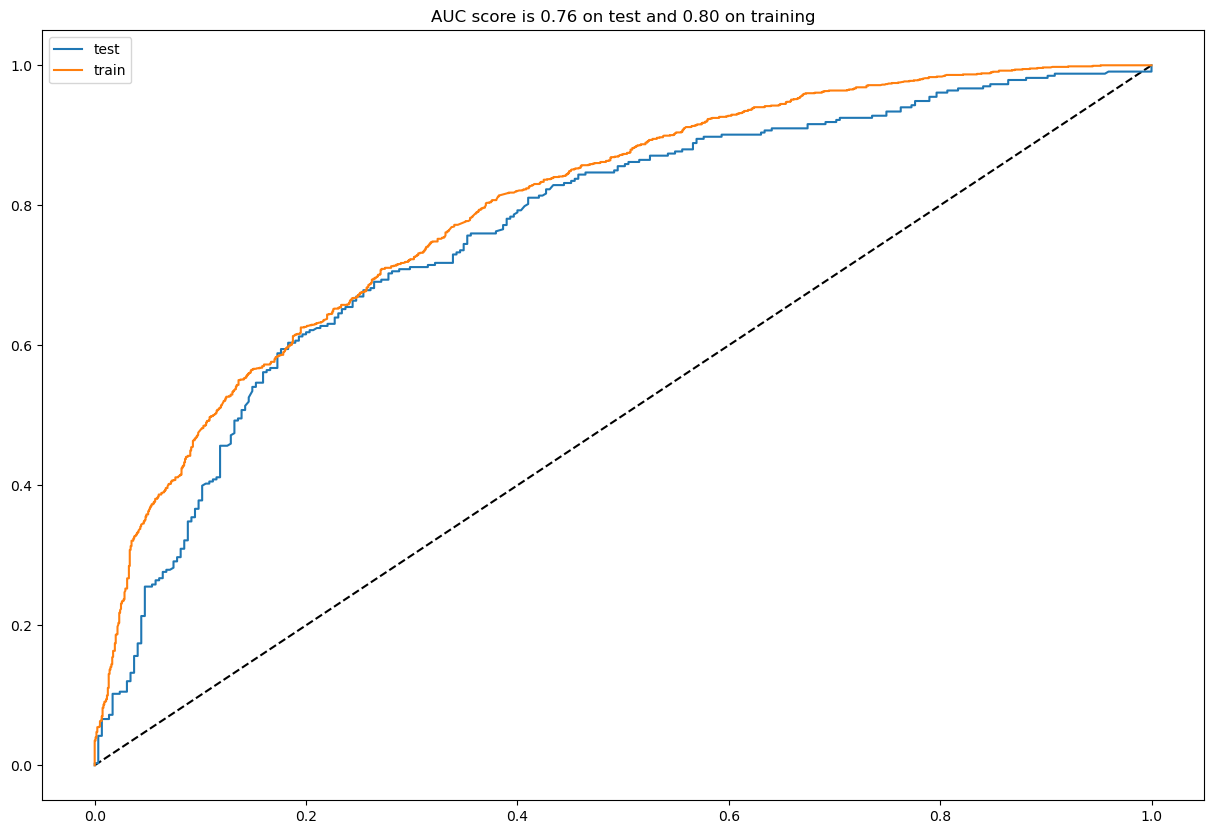

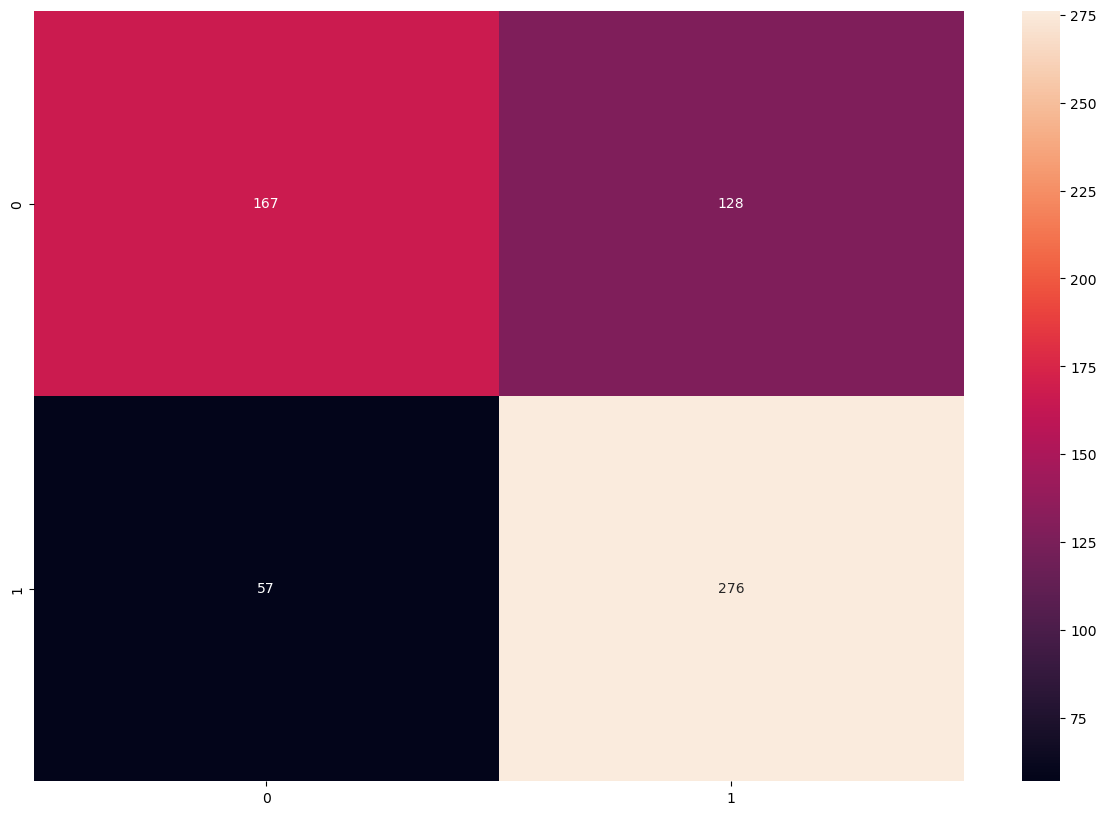

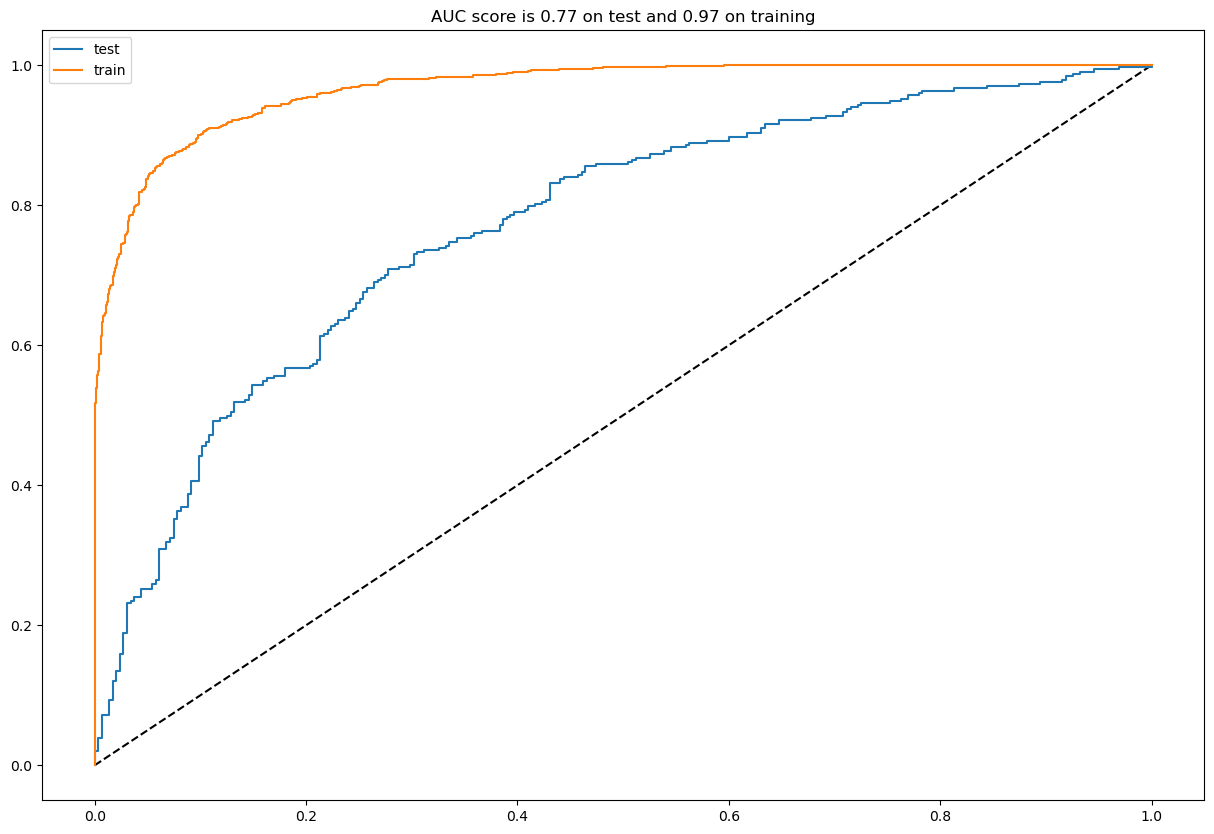

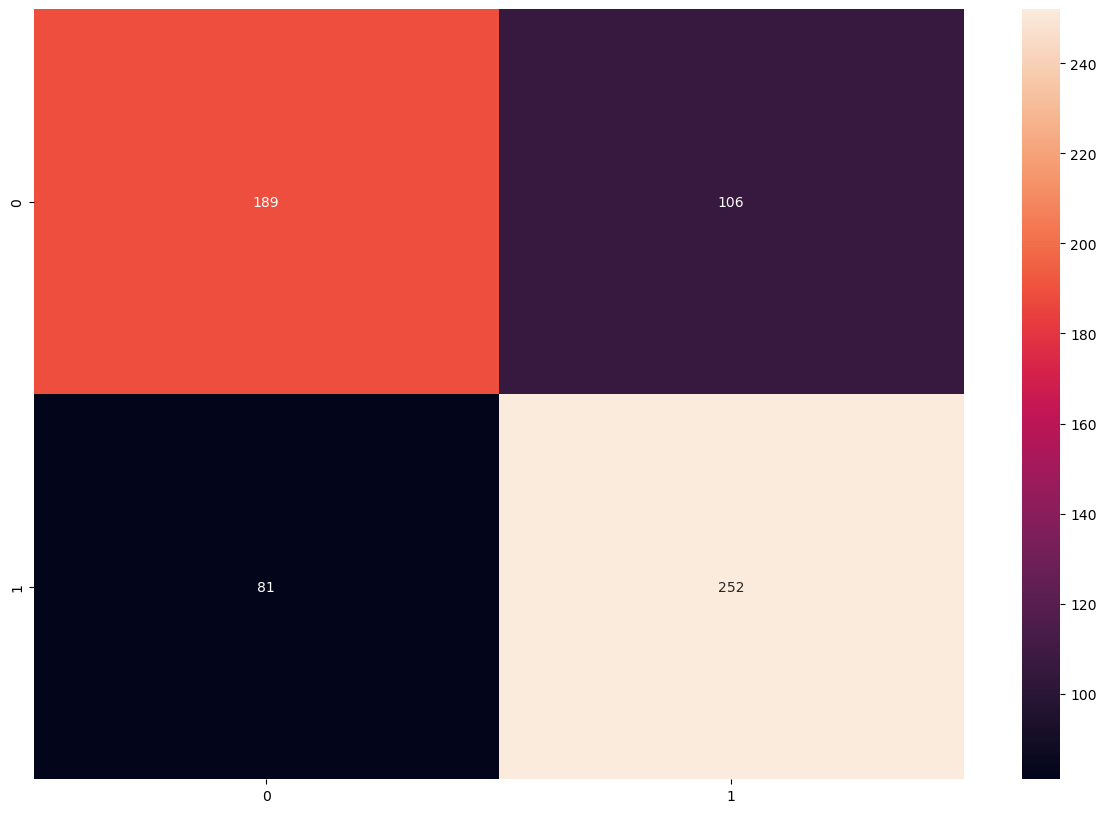

In [128]:
X = model_db.iloc[:, 3:]
y = model_db[["target"]]

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

gb = GradientBoostingClassifier(random_state=5)

params = {"learning_rate": [0.01, 0.1, 0.5],
            "min_samples_split": [5, 10],
            "min_samples_leaf": [3, 5],
            "max_depth":[3,5,10],
            "max_features":["sqrt"],
            "n_estimators":[100, 200]
         } 

gb_cv = GridSearchCV(gb, params, cv = 3, n_jobs = -1, verbose = False)

gb_cv.fit(X_train.values, np.ravel(y_train))

gb = gb_cv.best_estimator_

params_rf = {"max_depth": [20],
                "min_samples_split": [10],
                "max_leaf_nodes": [175],
                "min_samples_leaf": [5],
                "n_estimators": [250],
                 "max_features": ["sqrt"],
                }

rf = RandomForestClassifier(random_state=1)

rf_cv = GridSearchCV(rf, params_rf, cv = 3, n_jobs = -1, verbose = False)

rf_cv.fit(X_train.values, np.ravel(y_train))

rf = rf_cv.best_estimator_

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

def analyze(model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d")
    
analyze(gb)

analyze(rf)

from operator import itemgetter

# Playoffs World Cup Simulation

In [129]:
def find_stats(team_1):
    past_games = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date")
    last5 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games.score.mean()
    team_1_goals_l5 = last5.score.mean()
    team_1_goals_suf = past_games.suf_score.mean()
    team_1_goals_suf_l5 = last5.suf_score.mean()
    team_1_rank_suf = past_games.rank_suf.mean()
    team_1_rank_suf_l5 = last5.rank_suf.mean()
    team_1_gp_rank = past_games.points_by_rank.mean()
    team_1_gp_rank_l5 = last5.points_by_rank.mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]


def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

In [130]:
advanced = advanced_group
playoffs
advanced = [['Netherlands', 'Senegal'],
 ['England', 'United States'],
 ['Argentina', 'Poland'],
 ['France', 'Australia'],
 ['Japan', 'Spain'],
 ['Morocco', 'Croatia'],
 ['Brazil', 'Switzerland'],
 ['Portugal', 'South Korea']]

In [131]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [132]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
            

----------
Starting simulation of Round of 16
----------


Netherlands vs. United States: Netherlands advances with prob 0.52
Argentina vs. Australia: Argentina advances with prob 0.57
Japan vs. Croatia: Croatia advances with prob 0.54
Brazil vs. South Korea: Brazil advances with prob 0.55
Senegal vs. England: England advances with prob 0.52
Poland vs. France: France advances with prob 0.54
Spain vs. Morocco: Spain advances with prob 0.53
Switzerland vs. Portugal: Portugal advances with prob 0.52
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Argentina: Argentina advances with prob 0.52
Croatia vs. Brazil: Brazil advances with prob 0.52
England vs. France: France advances with prob 0.50
Spain vs. Portugal: Spain advances with prob 0.52
----------
Starting simulation of Semi-Final
----------


Argentina vs. Brazil: Brazil advances with prob 0.51
France vs. Spain: France advances with prob 0.53
----------
Starting simulation of Final
----------


Brazil vs. 

NetworkXError: Node 0 has no position.

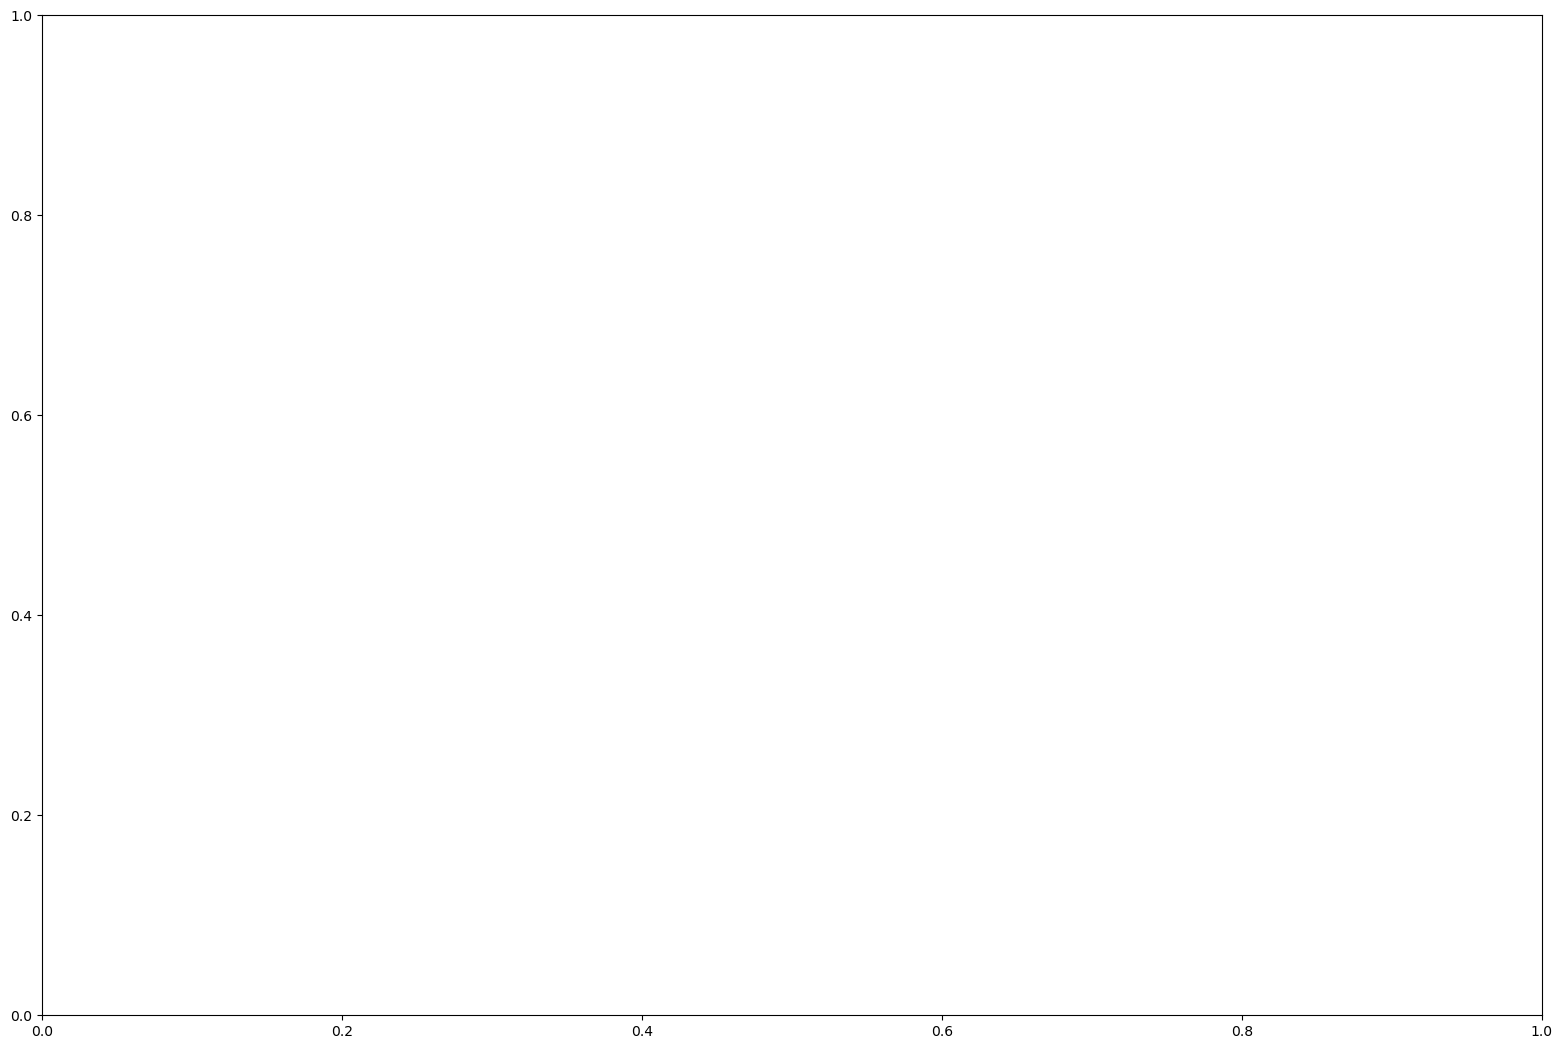

In [133]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

plt.figure(figsize=(15, 10))
G = nx.balanced_tree(2, 3)


labels = []


for p in playoffs.keys():
    for game in playoffs[p]:
        label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
        labels.append(label)
    
labels_dict = {}
labels_rev = list(reversed(labels))

for l in range(len(list(G.nodes))):
    labels_dict[l] = labels_rev[l]

pos = graphviz_layout(G, prog='twopi')
labels_pos = {n: (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
center  = pd.DataFrame(pos).mean(axis=1).mean()
    

nx.draw(G, pos = pos, with_labels=False, node_color=range(15), edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=5000)
nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=labels_dict)
texts = ["Round \nof 16", "Quarter \n Final", "Semi \n Final", "Final\n"]
pos_y = pos[0][1] + 55
for text in reversed(texts):
    pos_x = center
    pos_y -= 75 
    plt.text(pos_y, pos_x, text, fontsize = 18)

plt.axis('equal')
plt.show()